In [1]:
import numpy as np
import sys
import os
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_cellwise_df_100samplesperfile, extract_noise

In [3]:
data_path = 'C:/Users/vpming/tuni_ml/data'
all_df = build_cellwise_df_100samplesperfile(data_path)

In [4]:
min_count = all_df['dis_to_target'].value_counts().min()

n_samples = min_count

# Balance the df
df = (
    all_df.groupby('dis_to_target', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

print(df['dis_to_target'].value_counts())

dis_to_target
0    20000
1    20000
2    20000
3    20000
Name: count, dtype: int64


C:\Users\vpming\AppData\Local\Temp\ipykernel_15332\1389712327.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


In [5]:
df['noise'] = df['simulation_file'].apply(extract_noise)

In [13]:
print(df['noise'].value_counts())

noise
0.02    16162
0.01    16055
0.03    15998
0.05    15985
0.04    15800
Name: count, dtype: int64


In [6]:
x = np.stack(df['time_trace'])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3
n_bins = 4
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

# Do NOT scale y for classification!
train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * (n_timepoints // 4), 64),
            nn.ReLU(),
            nn.Linear(64, n_classes) 
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.fc(x)  

In [8]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [9]:
def fit(model, train_loader, test_loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/balanced_cnn_classifier_dtt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/20 Train Loss: 0.8235  Train Accuracy: 60.40%  Test Loss: 0.8699  Test Accuracy: 58.28%
Epoch 10/20 Train Loss: 0.6940  Train Accuracy: 67.32%  Test Loss: 0.9569  Test Accuracy: 56.53%
Epoch 15/20 Train Loss: 0.5368  Train Accuracy: 75.73%  Test Loss: 1.2596  Test Accuracy: 54.56%
Epoch 20/20 Train Loss: 0.3882  Train Accuracy: 83.40%  Test Loss: 1.8454  Test Accuracy: 53.54%


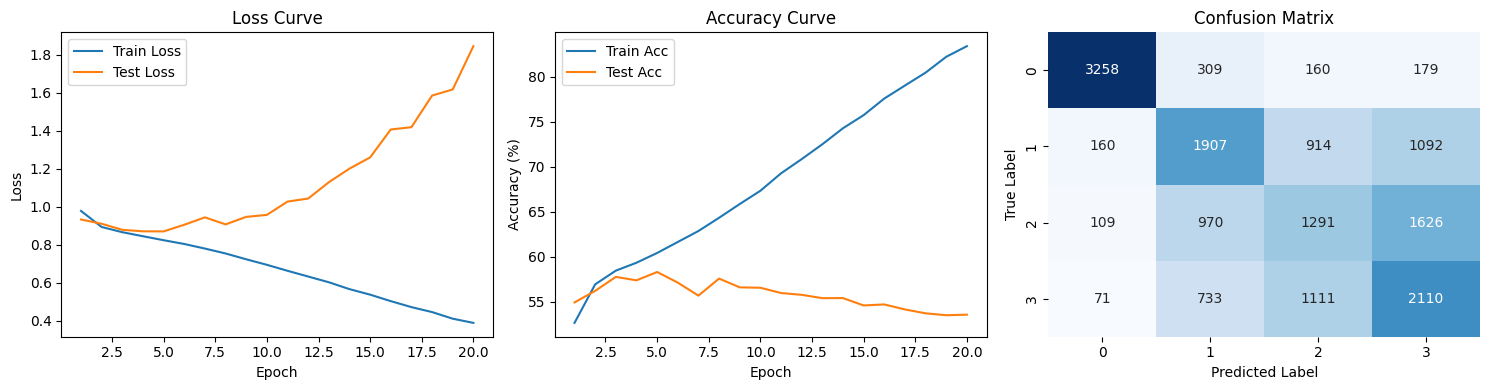

([0.977633269906044,
  0.8931801897287369,
  0.8657283414006233,
  0.8445089938640594,
  0.8235425379276275,
  0.803666931539774,
  0.7795244488120079,
  0.7536847881674766,
  0.7230856943726539,
  0.6939882728159428,
  0.6624795176684857,
  0.6323106845915317,
  0.6020904933214187,
  0.5659223954379559,
  0.536809305101633,
  0.5027081120312213,
  0.4712105944752693,
  0.4451000295877457,
  0.4102089563459158,
  0.38816331411898136],
 [0.9327320272922516,
  0.9100855784416199,
  0.8782453362941742,
  0.870382702589035,
  0.8699083824157715,
  0.9049509851932526,
  0.9439326665401458,
  0.9068467552661896,
  0.9464041812419891,
  0.9569007267951966,
  1.027011305809021,
  1.0429786217212678,
  1.1288774697780608,
  1.2005636236667634,
  1.259610633134842,
  1.4066821975708008,
  1.4187391419410706,
  1.5853069410324097,
  1.6174690580368043,
  1.8454295423030853],
 [52.6234375,
  56.909375,
  58.4328125,
  59.3125,
  60.3984375,
  61.6203125,
  62.8421875,
  64.3125,
  65.840625,
  67.

In [10]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = CNNClassifier(n_timepoints, n_classes)

fit(model, train_loader, test_loader)


=== Training for noise 0.01 ===
Training on 12844 samples; Testing on 3211 samples
Epoch 5/15 Train Loss: 0.6768  Train Accuracy: 66.88%  Test Loss: 0.6916  Test Accuracy: 65.40%
Epoch 10/15 Train Loss: 0.6109  Train Accuracy: 70.88%  Test Loss: 0.6891  Test Accuracy: 66.24%
Epoch 15/15 Train Loss: 0.4987  Train Accuracy: 77.87%  Test Loss: 0.8091  Test Accuracy: 65.37%


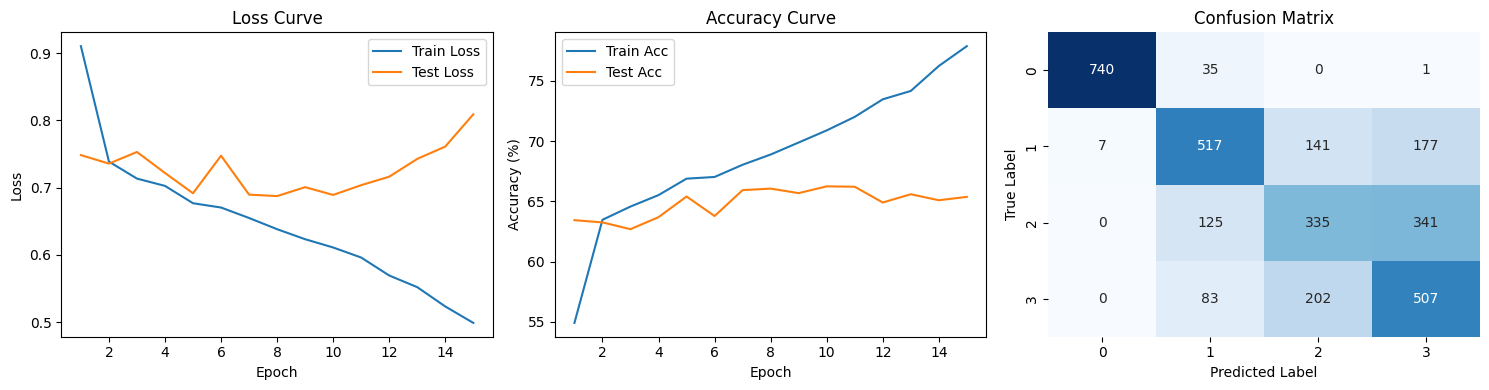


=== Training for noise 0.02 ===
Training on 12929 samples; Testing on 3233 samples
Epoch 5/15 Train Loss: 0.7669  Train Accuracy: 63.01%  Test Loss: 0.8458  Test Accuracy: 59.08%
Epoch 10/15 Train Loss: 0.6400  Train Accuracy: 70.96%  Test Loss: 0.9023  Test Accuracy: 57.32%
Epoch 15/15 Train Loss: 0.3813  Train Accuracy: 84.80%  Test Loss: 1.3887  Test Accuracy: 53.14%


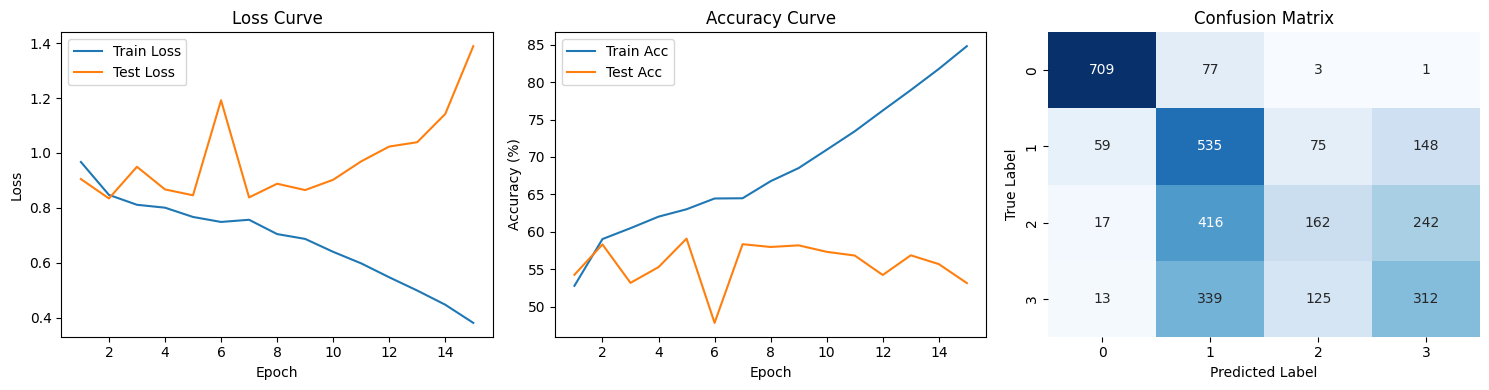


=== Training for noise 0.03 ===
Training on 12798 samples; Testing on 3200 samples
Epoch 5/15 Train Loss: 0.8343  Train Accuracy: 60.67%  Test Loss: 0.9170  Test Accuracy: 54.31%
Epoch 10/15 Train Loss: 0.6209  Train Accuracy: 73.14%  Test Loss: 1.0080  Test Accuracy: 53.91%
Epoch 15/15 Train Loss: 0.2510  Train Accuracy: 90.96%  Test Loss: 1.6174  Test Accuracy: 53.00%


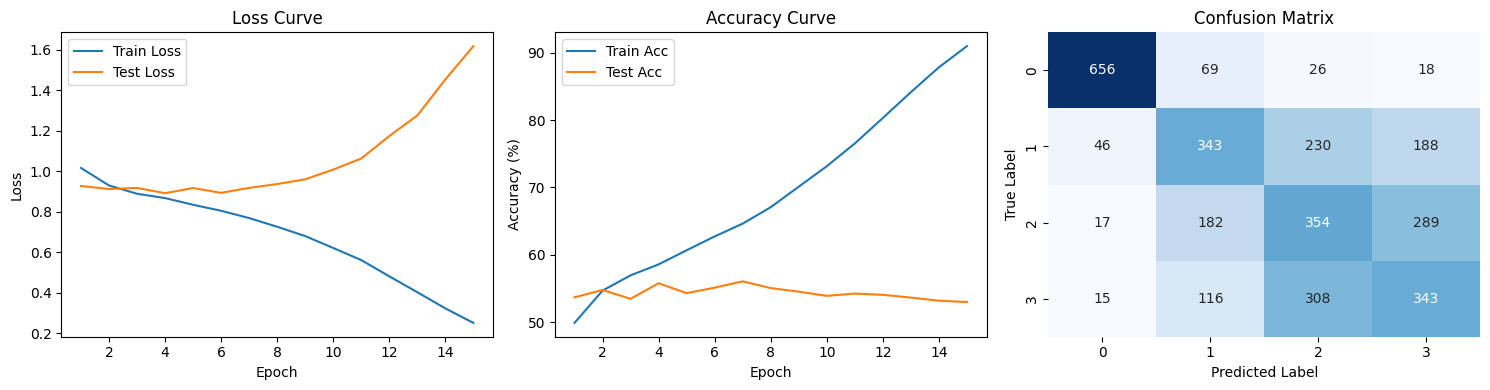


=== Training for noise 0.04 ===
Training on 12640 samples; Testing on 3160 samples
Epoch 5/15 Train Loss: 0.9107  Train Accuracy: 58.09%  Test Loss: 0.9986  Test Accuracy: 51.77%
Epoch 10/15 Train Loss: 0.6051  Train Accuracy: 74.93%  Test Loss: 1.2494  Test Accuracy: 49.43%
Epoch 15/15 Train Loss: 0.1847  Train Accuracy: 94.06%  Test Loss: 2.1867  Test Accuracy: 49.53%


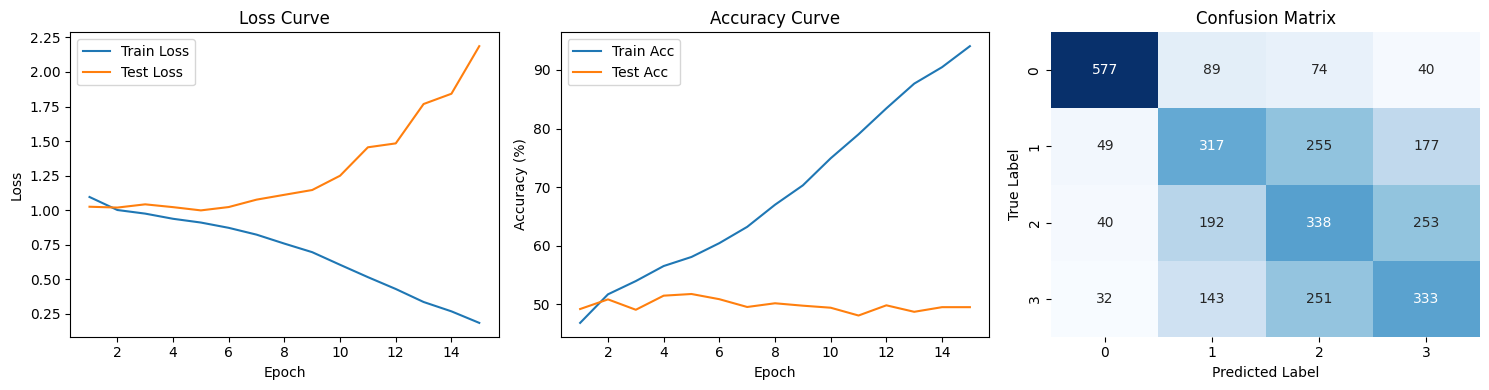


=== Training for noise 0.05 ===
Training on 12788 samples; Testing on 3197 samples
Epoch 5/15 Train Loss: 0.9697  Train Accuracy: 55.24%  Test Loss: 1.0507  Test Accuracy: 50.80%
Epoch 10/15 Train Loss: 0.7601  Train Accuracy: 67.02%  Test Loss: 1.2033  Test Accuracy: 47.04%
Epoch 15/15 Train Loss: 0.4043  Train Accuracy: 84.46%  Test Loss: 1.7579  Test Accuracy: 45.73%


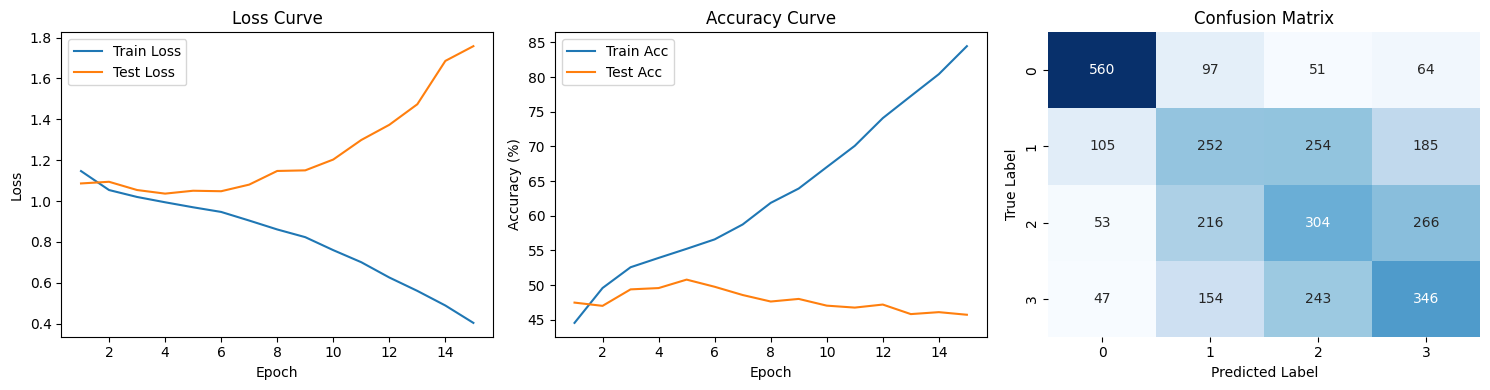

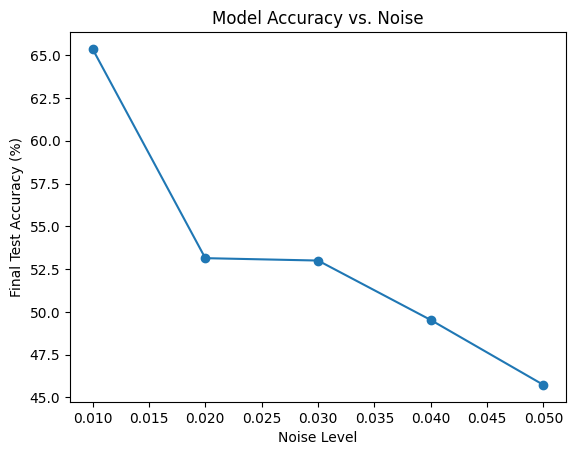

In [14]:
df['noise'] = df['simulation_file'].apply(extract_noise)

results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    X = np.stack(df.loc[mask, 'time_trace'])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 4
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = CNNClassifier(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise") 
plt.show()